In [ ]:
# DEMO CODE👇
%%time


In [ ]:
!nvidia-smi

RAPIDSAI referenec: https://docs.rapids.ai/install#rapids-release-selector

In [1]:
!pip install cuml_cu11==23.04.00 --extra-index-url https://pypi.nvidia.com 
!pip install cudf_cu11==23.04.00 --extra-index-url https://pypi.nvidia.com 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 728.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 957.1/957.1 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.1/215.1 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 92.3 MB/s eta

In [2]:
# For data processing
import numpy as np
import pandas as pd

# For Visulization
import matplotlib.pyplot as plt
import seaborn as sns

# For GPU Processing
import cudf
import cupy as cp
import cuml

# Save features as a pickle file
import pickle


# For Random Forest using GPU
from cuml.ensemble import RandomForestRegressor
from cuml.metrics.accuracy import accuracy_score

In [6]:
with open('/content/drive/MyDrive/datasets/stock-prices-S&P-constituents/datasets-list', 'rb') as file:
    datasets = pickle.load(file)

In [7]:
with open('/content/drive/MyDrive/datasets/stock-prices-S&P-constituents/symbols', 'rb') as file:
  symbols = pickle.load(file)

In [10]:
len(datasets)

26

In [11]:
# This function will generate new features for Random Forest
def generate_features_rf(current_data):
    curr_dataset = cp.asarray(current_data.copy())

    # Take the total amount of days in 1st study period
    T_study = curr_dataset.shape[1]

    # Create the t =[241, 243, ..., T_study]
    t = cp.arange(240, T_study)

    # Define the m for calculation of t-m, m = [1, 2, 3, ..., 20]
    M = cp.arange(1, 21)

    # m = [1, 2, 3, ..., 20] U [40, 60, 80, ..., 240]
    M = cp.concatenate((M, cp.arange(40, 241, 20)))

    # Define number of stocks as it will be used to create arrays with proper shapes
    n_stocks = 251

    # Create a container to store ir, cr and or for the current dataset and targets to store targets
    features_container = cp.ones(shape=(n_stocks, T_study, M.shape[0]*3))
    targets = cp.ones(shape=(n_stocks, T_study, 1))

    # Put NaN values to the first 240 rows as it will be used for feature creation
    features_container[:, :t[0], :] = cp.nan 
    targets[:, :t[0], :] = cp.nan

    # To calculate ir, we need cp_(t-m) and op_(t-m)
    cp_t_m = cp.zeros((n_stocks, t.shape[0], M.shape[0]))
    op_t_m = cp.zeros((n_stocks, t.shape[0], M.shape[0]))

    # To calculate cr, we need cp_(t-1-m) and cp_(t-1-m). Remember we are indexing from 0, not 1!
    cp_t_1_m = cp.zeros((n_stocks, t.shape[0], M.shape[0]))
    cp_t_1 = curr_dataset[:, t-2, 0]

    # To calculate or, we need op_t and cp_t_m. Remember we are indexing from 0, not 1!
    op_t = curr_dataset[:, t-1, 1]


    # Calculate cp_(t-m), op_(t-m) and cp_(t-1-m) for each m and store them at proper axis=2 index i
    # of their respective container
    for i, m in enumerate(M):
        cp_t_m[:, :, i] = curr_dataset[:, t-m, 0]
        op_t_m[:, :, i] = curr_dataset[:, t-m, 1]
        cp_t_1_m[:, :, i] = curr_dataset[:, t-1-m, 0]


    # Calculate ir_(t-m)
    ir_t_m = cp.divide(cp_t_m, op_t_m, out=cp.zeros_like(cp_t_m)) - 1


    # Before calculating cr_(t-m), reshape the cp_(t-1-m) as it should have the same last part of shape as cp_(t-1), the divident
    # means if cp_(t-1) is (251, 774) then cp_(t-1-m) should be (_, 251, 774) notice the last of shape is same
    reshaped_cp_t_1_m = cp_t_1_m.reshape(M.shape[0], n_stocks, -1)

    # Calculating cr_(t-m)
    cr_t_m = cp.divide(cp_t_1, reshaped_cp_t_1_m).reshape(n_stocks, -1, M.shape[0]) - 1


    # Before calculating or_(t-m), reshape the cp_(t-m) as it should have the same last part of shape as op_t, the divident
    # means if op_t is (251, 774) then cp_(t-m) should be (_, 251, 774) notice the last of shape is same
    reshaped_cp_t_m = cp_t_m.reshape(M.shape[0], n_stocks, -1)

    # Calculating or_(t-m)
    or_t_m = cp.divide(op_t, reshaped_cp_t_m).reshape(n_stocks, -1, M.shape[0]) - 1

    # Calculate targets
    cp_t0 = curr_dataset[:, t, 0:1] # 0:1 makes sure that it is 3D just like targets[:, t, :]
    op_t0 = curr_dataset[:, t, 1:] # 1: makes sure that it is 3D just like targets[:, t, :]
    targets[:, t, :] = cp.divide(cp_t0, op_t0, out=cp.zeros_like(cp_t0), _where=op_t0!=0)

    # Put the ir, cr and or inside the container
    features_container[:, t, :] = cp.dstack((ir_t_m, cr_t_m, or_t_m))

    return features_container, targets

In [12]:
# It will contain all the newly processed datasets each with a shape (251, stock days in 4 years, 93)
containers = []
targets = []

# Run the generate_feature_rf function for each dataset inside main_datasets
for dataset in datasets:
  dataset = dataset.astype(np.float64)
  features, target = generate_features_rf(dataset)
  containers.append(features)
  targets.append(target)

In [13]:
len(containers), len(targets)

(26, 26)

251 Stocks, ~1008 Days recorded, 93 Features

In [14]:
# Create the RandomForest Model with GPU
rf_reg = RandomForestRegressor(n_estimators=1000, max_depth=10)
train_test_accuracy = []

for curr_dataset, curr_targets in zip(containers, targets):
  # Remove the days which were used for features creation
  X = curr_dataset[:, 252:, :]
  y = curr_targets[:, 252:, :]

  # training data contains 2 years and testing data is of 1 year
  train_size=252*2
  test_size=252

  n_stocks = X.shape[0]
  n_features = X.shape[2]

  # Split the dataset into training and testing data
  X_train, X_test, y_train, y_test = \
  X[:, :train_size, :], X[:, train_size:, :], \
  y[:, :train_size, :], y[:, train_size:, :]
  
  # Store the no of days captured for training and testing to use it later for reshaping the results back to original
  n_train_days = X_train.shape[1]
  n_test_days = X_test.shape[1]

  # Reshape the training and testing data for model training and testing
  X_train = X_train.reshape(-1, n_features)
  X_test = X_test.reshape(-1, n_features)
  y_train = y_train.reshape(-1, 1)
  y_test = y_test.reshape(-1, 1)

  rf_reg.fit(X_train, y_train)
  
  train_pred = rf_reg.predict(X_train)
  test_pred = rf_reg.predict(X_test)

  train_acc = accuracy_score(y_train, train_pred)
  test_acc = accuracy_score(y_test, test_pred)

  train_test_accuracy.append([train_acc, test_acc])

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [15]:
train_test_accuracy

[[0.9772418141365051, 0.9758630990982056],
 [0.9772734642028809, 0.9757376909255981],
 [0.9770047068595886, 0.9748613238334656],
 [0.9796765446662903, 0.9783923029899597],
 [0.9794868230819702, 0.9784079194068909],
 [0.9795263409614563, 0.978439211845398],
 [0.9812654256820679, 0.978064239025116],
 [0.9800401329994202, 0.9763790965080261],
 [0.9783406257629395, 0.9749550223350525],
 [0.9800875782966614, 0.9784731864929199],
 [0.9808148145675659, 0.9772201776504517],
 [0.9807674288749695, 0.9769149422645569],
 [0.9810994267463684, 0.9775500893592834],
 [0.9816685914993286, 0.9770797491073608],
 [0.9824116230010986, 0.9785179495811462],
 [0.9823721051216125, 0.9726988673210144],
 [0.9773999452590942, 0.9712226986885071],
 [0.9759849309921265, 0.9741352200508118],
 [0.977384090423584, 0.9750090837478638],
 [0.9781034588813782, 0.9741195440292358],
 [0.9784196615219116, 0.9732908606529236],
 [0.9778030514717102, 0.9739920496940613],
 [0.978095531463623, 0.9729083776473999],
 [0.97729718685

In [16]:
len(train_test_accuracy)

26

In [17]:
train_test_accuracy[0][0]

0.9772418141365051

In [18]:
train_acc = [acc[0] for acc in train_test_accuracy]
test_acc = [acc[1] for acc in train_test_accuracy]

train_acc, test_acc

([0.9772418141365051,
  0.9772734642028809,
  0.9770047068595886,
  0.9796765446662903,
  0.9794868230819702,
  0.9795263409614563,
  0.9812654256820679,
  0.9800401329994202,
  0.9783406257629395,
  0.9800875782966614,
  0.9808148145675659,
  0.9807674288749695,
  0.9810994267463684,
  0.9816685914993286,
  0.9824116230010986,
  0.9823721051216125,
  0.9773999452590942,
  0.9759849309921265,
  0.977384090423584,
  0.9781034588813782,
  0.9784196615219116,
  0.9778030514717102,
  0.978095531463623,
  0.9772971868515015,
  0.9767991304397583,
  0.9764038920402527],
 [0.9758630990982056,
  0.9757376909255981,
  0.9748613238334656,
  0.9783923029899597,
  0.9784079194068909,
  0.978439211845398,
  0.978064239025116,
  0.9763790965080261,
  0.9749550223350525,
  0.9784731864929199,
  0.9772201776504517,
  0.9769149422645569,
  0.9775500893592834,
  0.9770797491073608,
  0.9785179495811462,
  0.9726988673210144,
  0.9712226986885071,
  0.9741352200508118,
  0.9750090837478638,
  0.974119544

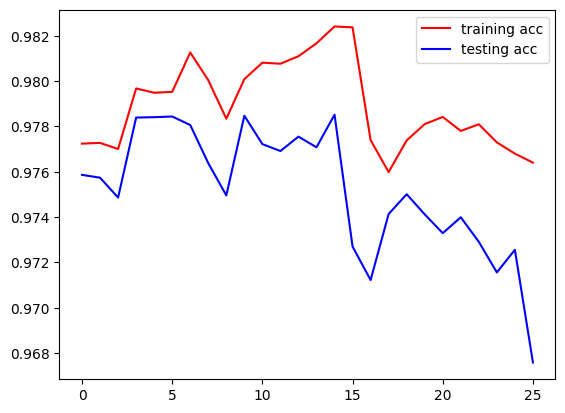

In [19]:
plt.plot(range(len(train_acc)), train_acc, 'r-', label="training acc")
plt.plot(range(len(test_acc)), test_acc, 'b-', label="testing acc")

plt.legend()

In [21]:
with open('rf_stocks.pkl', 'wb') as file:
  pickle.dump(rf_reg, file)

In [22]:
from google.colab import files
files.download('rf_stocks.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load the model

In [23]:
def display_topbtm_stocks(prediction, label="Prediction",
                      k = 5,
                      n_features=93, n_stocks=251, 
                      train_size=252*2, test_size=252):

  # Reverse back the shapes to map the stock indexes to symbol list
  prediction = prediction.reshape(n_stocks, 1, 1)

  # Find the top and bottom k stocks using argsort which will return the indexes
  top_k_stocks = cp.argsort(prediction, axis=0)[:k,0,-1]
  bottom_k_stocks = cp.argsort(prediction, axis=0)[-k:,0,-1]

  # Print the Predicted/Actual top k and bottom k stocks
  print(label, ":")
  # Iterate over all k stock indixces and as they are type cupy.array(), convert it to scalar using .item()
  print("Top k: ", ' '.join([f"{symbols[i.item()]}" for i in top_k_stocks[:]]))
  print("Bottom k: ", ' '.join([f"{symbols[i.item()]}" for i in bottom_k_stocks[:]]))

In [28]:
def dummy_func(model, dataset_idx=0, day=23):
  curr_dataset = containers[dataset_idx]
  curr_targets = targets[dataset_idx]

  X_test = curr_dataset[:, day, :]
  y_test = curr_targets[:, day, -1]

  # Reshape the training and testing data for model training and testing
  X_test = X_test.reshape(-1, n_features)
  y_test = y_test.reshape(-1, 1)

  prediction = model.predict(X_test)

  display_topbtm_stocks(prediction)
  display_topbtm_stocks(y_test, "Actual")

In [29]:
dummy_func(rf_reg, 1)

Prediction :
Top k:  AAPL ABT ADBE ADI ADM
Bottom k:  WY XEL XOM XRAY ZION
Actual :
Top k:  AAPL ABT ADBE ADI ADM
Bottom k:  WY XEL XOM XRAY ZION
